In [104]:
user_name = "parasyte" 
root_dir = f"/tmp/finn_dev_{user_name}"
print(root_dir)
# get onnx model from the last NOTEBOOK
filename = root_dir + "/ready_finn.onnx"

/tmp/finn_dev_parasyte


In [105]:
from finn.util.visualization import showSrc, showInNetron


In [106]:
# showInNetron(filename)

In [107]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.core.modelwrapper import ModelWrapper

model = ModelWrapper(filename)

# TIDY UP
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save(root_dir + "/tidy.onnx")

showSrc(InferShapes)
# showInNetron(root_dir + "/tidy.onnx")

class InferShapes(Transformation):
    """Ensure every tensor in the model has a specified shape (ValueInfo)."""

    def apply(self, model):
        # hide your riches!
        hidden_ops = _hide_finn_ops(model)
        # call regular ONNX shape inference
        model = ModelWrapper(si.infer_shapes(model.model))
        # bring back hidden ops
        _restore_finn_ops(model, hidden_ops)
        return (model, False)



In [108]:
# --------------------
# Preprocesamiento 
# --------------------


from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
import torch
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

model = ModelWrapper(root_dir + "/tidy.onnx")
global_inp_name = model.graph.input[0].name
# Transformamos a UINTT8 de 0 a 255, para ponerlo en hardware, ya que no se puede usar float32 
model.set_tensor_datatype(global_inp_name, DataType["UINT8"]) 


model.save(root_dir + "/full_preproc.onnx")
# showInNetron(root_dir + "/full_preproc.onnx")

In [109]:

from qonnx.transformation.insert_topk import InsertTopK
# ---------------
# Post Procesado
# ---------------

model = model.transform(InsertTopK(k=1))
chkpt_name = root_dir + "/pre_post.onnx"
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

# showInNetron(chkpt_name)

In [110]:
# ------------------
# Model streamlining
# ------------------

from finn.transformation.streamline import Streamline
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper(root_dir + "/pre_post.onnx")

# Obtener un modelo entero de Enteros para la inferencia y un grafico facil de transformar a capas HW

model = model.transform(Streamline()) 
model.save(root_dir + "/streamlined.onnx")
# showInNetron(root_dir + "/streamlined.onnx")

In [111]:
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors
import finn.transformation.streamline.absorb as absorb
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.infer_data_layouts import InferDataLayouts



model = ModelWrapper(root_dir + "/streamlined.onnx")

model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model = model.transform(InferShapes())
model = model.transform(InferDataTypes())
model = model.transform(RemoveUnusedTensors())


model.save(root_dir + "/streamlined_merged_and_ready.onnx")
# showInNetron(root_dir + "/streamlined_merged_and_ready.onnx")

/home/parasyte/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:127: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [112]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from qonnx.core.modelwrapper import ModelWrapper

# ---------------------
# Convertir a Capas HW
# ---------------------
# No genera codigo HLS o RTL
# Se combinan operaciones en unidades (MVAU o SWU) para que FINN maneje las capas. 


model = ModelWrapper(root_dir + "/streamlined_merged_and_ready.onnx")
model = model.transform(to_hw.InferLabelSelectLayer())
model = model.transform(to_hw.InferChannelwiseLinearLayer())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())
model = model.transform(to_hw.InferThresholdingLayer())
model.save(root_dir + "/hw.onnx")
# showInNetron(root_dir + "/hw.onnx")

/home/parasyte/finn/src/finn/transformation/fpgadataflow/convert_to_hw_layers.py:668: UserWarning: Broadcasting Mul(Mul_0)
  warnings.warn("Broadcasting " + str(node.op_type) + "(" + node.name + ")")


In [113]:
from qonnx.core.modelwrapper import ModelWrapper


hw_model = ModelWrapper(root_dir + "/hw.onnx")

# listar todos los tipos de nodos que contiene, para ver si es completamente HW o HW + CPU
op_types = set([n.op_type for n in hw_model.graph.node])
print("Tipos de nodos encontrados en hw.onnx:\n", op_types)



Tipos de nodos encontrados en hw.onnx:
 {'Add', 'TopK', 'Reshape', 'MVAU', 'Mul'}


In [114]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

# Una vez inferidas las MVAU, FINN puede dividir las capas convertibles a hardware en particiones de dataflow.
# En caso encuentre capas que no puedan ser HW, se hara procesamiento por CPU

model = ModelWrapper(root_dir + "/hw.onnx")


parent_model = model.transform(CreateDataflowPartition())
parent_model.save(root_dir + "/df_part.onnx")
# showInNetron(root_dir + "/df_part.onnx")

In [115]:
from qonnx.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
# showInNetron(dataflow_model_filename)

In [116]:
# --------------------
# MVAU HLS Conversion
# --------------------

from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

pynq_board = "Pynq-Z2"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 20

dict_keys(['Ultra96', 'Ultra96-V2', 'Pynq-Z1', 'Pynq-Z2', 'ZCU102', 'ZCU104', 'ZCU111', 'RFSoC2x2', 'RFSoC4x2', 'KV260_SOM'])


In [117]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
model = ModelWrapper(dataflow_model_filename)

model = model.transform(SpecializeLayers(fpga_part))

showSrc(SpecializeLayers)

model.save(root_dir + "/to_hw_conv.onnx")
# showInNetron(root_dir + "/to_hw_conv.onnx")

class SpecializeLayers(Transformation):
    """Specialize all layers to either HLS or RTL variants"""

    def __init__(self, fpgapart):
        super().__init__()
        self.fpgapart = fpgapart

    def apply(self, model):
        graph = model.graph
        node_ind = 0
        graph_modified = False
        for node in graph.node:
            # Skip nodes that are not hw layers
            if not node.domain == "finn.custom_op.fpgadataflow":
                continue
            node_ind += 1
            impl_style = _determine_impl_style(node, self.fpgapart, model)
            optype = node.op_type + "_" + impl_style

            new_node = helper.make_node(
                optype,
                node.input,
                node.output,
                domain="finn.custom_op.fpgadataflow." + impl_style,
            )
            # add all attributes
            for attribute in node.attribute:
                if attribute.name != "preferred_impl_style":
                    new_no

In [118]:
# ----------------------
# FOLDING PARAMETER AND LOOP UNROLLING
# ----------------------

# Folding describe el proceso de loop unrolling, es decir, cuánto cálculo se ejecuta en paralelo.

model = ModelWrapper(root_dir + "/to_hw_conv.onnx")

fc0 = model.graph.node[0] #1st MVAU
fc0w = getCustomOp(fc0)

print("CustomOp wrapper is of class " + fc0w.__class__.__name__)

fc0w.get_nodeattr_types()

CustomOp wrapper is of class MVAU_hls


{'PE': ('i', True, 0),
 'SIMD': ('i', True, 0),
 'MW': ('i', True, 0),
 'MH': ('i', True, 0),
 'resType': ('s', False, 'auto', {'auto', 'dsp', 'lut'}),
 'ActVal': ('i', False, 0),
 'inputDataType': ('s', True, ''),
 'weightDataType': ('s', True, ''),
 'outputDataType': ('s', True, ''),
 'accDataType': ('s', False, 'INT32'),
 'binaryXnorMode': ('i', False, 0, {0, 1}),
 'noActivation': ('i', False, 0, {0, 1}),
 'numInputVectors': ('ints', False, [1]),
 'mem_mode': ('s',
  False,
  'internal_decoupled',
  {'external', 'internal_decoupled', 'internal_embedded'}),
 'ram_style': ('s', False, 'auto', {'auto', 'block', 'distributed', 'ultra'}),
 'ram_style_thresholds': ('s',
  False,
  'auto',
  {'auto', 'block', 'distributed'}),
 'runtime_writeable_weights': ('i', False, 0, {0, 1}),
 'backend': ('s', True, 'fpgadataflow'),
 'preferred_impl_style': ('s', False, '', {'', 'hls', 'rtl'}),
 'code_gen_dir_ipgen': ('s', False, ''),
 'ipgen_path': ('s', False, ''),
 'ip_path': ('s', False, ''),
 'ip_

In [119]:
from finn.transformation.fpgadataflow.set_folding import SetFolding

TARGET_FPS = 100
target_clk_cycles_per_frame = 1/(TARGET_FPS * 10e-9)

model = ModelWrapper(root_dir + "/to_hw_conv.onnx")
# Aplicar parametros autimaticamente
model.transform(SetFolding(target_cycles_per_frame=target_clk_cycles_per_frame, mvau_wwidth_max=64, two_pass_relaxation=False))

# NOTA: cambio de SIMD y PE, ya que al tener una entrada de 3072, se necesita cumplir con SIMD >= WHC/1024, WHC es la entrada de 3 x 32 x 32 
fc0 = model.graph.node[0]
fc0w = getCustomOp(fc0)
fc0w.set_nodeattr("SIMD",4)
fc0w.set_nodeattr("PE",1)
fc0w = getCustomOp(fc0)
print("SIMD:", fc0w.get_nodeattr("SIMD"))
print("PE:", fc0w.get_nodeattr("PE"))
model.save(root_dir + "/to_hw_folded.onnx")
# showInNetron(root_dir + "/to_hw_folded.onnx")

SIMD: 4
PE: 1


In [120]:
# Ejecutar un estimado basado en el target FPS

import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = root_dir + "/to_hw_folded.onnx"

estimates_output_dir = "output_estimates_only"

if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 64,
    target_fps          = 100,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

build.build_dataflow_cfg(model_file, cfg_estimates)

Running step: step_qonnx_to_finn [1/10]
Running step: step_tidy_up [2/10]
Running step: step_streamline [3/10]


Previous run results deleted!
Building dataflow accelerator from /tmp/finn_dev_parasyte/to_hw_folded.onnx
Intermediate outputs will be generated in /tmp/finn_dev_parasyte
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/10]
Running step: step_tidy_up [2/10]
Running step: step_streamline [3/10]


Running step: step_convert_to_hw [4/10]
Running step: step_create_dataflow_partition [5/10]
Running step: step_specialize_layers [6/10]
Running step: step_target_fps_parallelization [7/10]
Running step: step_apply_folding_config [8/10]
Running step: step_minimize_bit_width [9/10]
Running step: step_generate_estimate_reports [10/10]


Running step: step_convert_to_hw [4/10]
Running step: step_create_dataflow_partition [5/10]
Running step: step_specialize_layers [6/10]
Running step: step_target_fps_parallelization [7/10]
Running step: step_apply_folding_config [8/10]
Running step: step_minimize_bit_width [9/10]
Running step: step_generate_estimate_reports [10/10]
Completed successfully


0

In [121]:
! cat {estimates_output_dir}/report/estimate_network_performance.json


{
  "critical_path_cycles": 534592,
  "max_cycles": 524288,
  "max_cycles_node_name": "MVAU_hls_0",
  "estimated_throughput_fps": 190.73486328125,
  "estimated_latency_ns": 5345920.0
}

In [122]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'MVAU_hls_0': 524288,
 'MVAU_hls_1': 8192,
 'MVAU_hls_2': 2048,
 'MVAU_rtl_0': 64}

In [123]:
# Estimado de consumo de BRAM18K, LUT, URAM y DSP de cada capa, además del total
# Se usan para ver si es posible implementarlo en la pynq, ya que tenemos recursos limitados

read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")


{'MVAU_hls_0': {'BRAM_18K': 128,
  'BRAM_efficiency': 0.8888888888888888,
  'LUT': 377,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_1': {'BRAM_18K': 4,
  'BRAM_efficiency': 0.8888888888888888,
  'LUT': 371,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.8888888888888888,
  'LUT': 370,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_rtl_0': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.027777777777777776,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 1},
 'total': {'BRAM_18K': 134.0, 'LUT': 1118.0, 'URAM': 0.0, 'DSP': 1.0}}

In [124]:
# Construcción del Hardware utilizando Zynq Build

from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild

model = ModelWrapper(root_dir + "/to_hw_folded.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns,partition_model_dir="./test",enable_debug=True))

/home/parasyte/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 6 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/home/parasyte/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:234: UserWarning: Input FIFO for IODMA_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/parasyte/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:294: UserWarning: Output FIFO for MVAU_rtl_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/parasyte/finn/src/finn/transformation/fpgadataflow/create_stitched_ip.py:290: UserWarning: First node is not StreamingFIFO or IODMA.
                You may experience incorrect stitched-IP rtlsim or hardware
                behavior. It is strongly recommended to insert FIFOs prior to
               

In [125]:
model.save( "post_synth.onnx")

In [127]:
showInNetron("post_synth.onnx")


Serving 'post_synth.onnx' at http://0.0.0.0:8081


In [136]:
model = ModelWrapper("post_synth.onnx")

In [137]:
# VArchivos generados para el proyecto vivado
model.model.metadata_props

[key: "floorplan_json"
value: "/tmp/finn_dev_parasyte/vitis_floorplan_oat9d_pk/floorplan.json"
, key: "vivado_pynq_proj"
value: "/tmp/finn_dev_parasyte/vivado_zynq_proj_8tau95_q"
, key: "bitfile"
value: "/tmp/finn_dev_parasyte/vivado_zynq_proj_8tau95_q/resizer.bit"
, key: "hw_handoff"
value: "/tmp/finn_dev_parasyte/vivado_zynq_proj_8tau95_q/resizer.hwh"
, key: "vivado_synth_rpt"
value: "/tmp/finn_dev_parasyte/vivado_zynq_proj_8tau95_q/synth_report.xml"
, key: "platform"
value: "zynq-iodma"
]

In [138]:
# Creación del driver pynq para poder ejecutar un test implementado en PYNQ Z2

from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
model = model.transform(MakePYNQDriver("zynq-iodma"))

In [139]:
model.save("end2end_pynq_driver.onnx")

In [144]:
from finn.util.basic import make_build_dir
from shutil import copy
from distutils.dir_util import copy_tree

deployment_dir = make_build_dir(prefix="pynq_deployment_")
model.set_metadata_prop("pynq_deployment_dir", deployment_dir)

# driver.py y librerias
pynq_driver_dir = model.get_metadata_prop("pynq_driver_dir")
copy_tree(pynq_driver_dir, deployment_dir)

creating /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/finn
creating /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/finn/util
copying /tmp/finn_dev_parasyte/pynq_driver_uzarsa67/finn/util/__init__.py -> /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/finn/util
copying /tmp/finn_dev_parasyte/pynq_driver_uzarsa67/finn/util/data_packing.py -> /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/finn/util
creating /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/runtime_weights
copying /tmp/finn_dev_parasyte/pynq_driver_uzarsa67/driver_base.py -> /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty
creating /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx
creating /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/core
copying /tmp/finn_dev_parasyte/pynq_driver_uzarsa67/qonnx/core/__init__.py -> /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/core
copying /tmp/finn_dev_parasyte/pynq_driver_uzarsa67/qonnx/core/datatype.py -> /tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/core
c

['/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/finn/util/__init__.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/finn/util/data_packing.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/driver_base.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/core/__init__.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/core/datatype.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/util/__init__.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/qonnx/util/basic.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/validate.py',
 '/tmp/finn_dev_parasyte/pynq_deployment_qbb7hwty/driver.py']

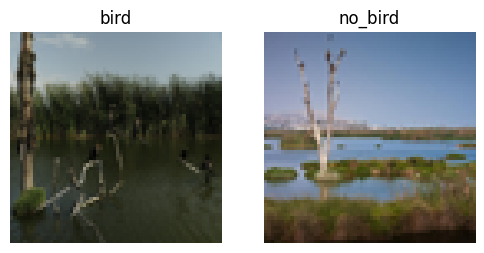

In [141]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ruta a tu dataset
dataset_dir = "Images_test"
classes = ["bird", "no_bird"]

plt.figure(figsize=(6, 3))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(dataset_dir, cls)
    
    # tomar la primera imagen de la clase
    img_name = next(fname for fname in os.listdir(cls_dir) if fname.endswith((".png", ".jpg")))
    img_path = os.path.join(cls_dir, img_name)
    
    # abrir imagen y convertir a RGB
    img = Image.open(img_path).convert("RGB")
    
    # cambiar tamaño a 32x32
    img = img.resize((64, 64))
    
    # convertir a numpy array y reorganizar ejes para HWC
    x = np.array(img)
    x = x.transpose(2, 0, 1).transpose(1, 2, 0)  # formato HWC
    
    # mostrar imagen
    plt.subplot(1, 2, i+1)
    plt.imshow(x)
    plt.title(cls)
    plt.axis("off")

plt.show()


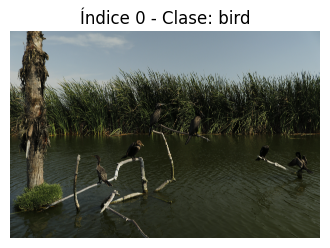

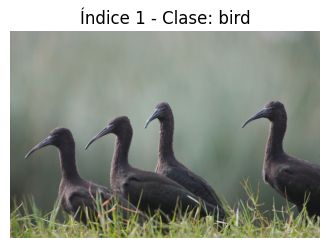

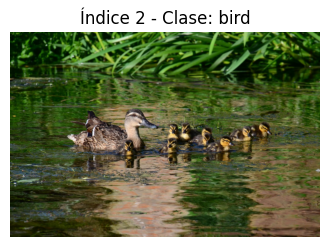

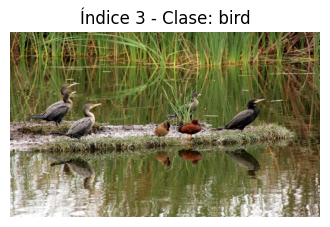

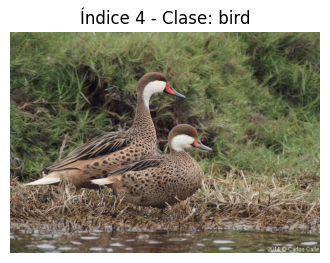

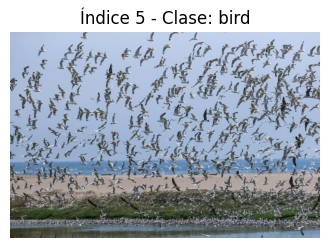

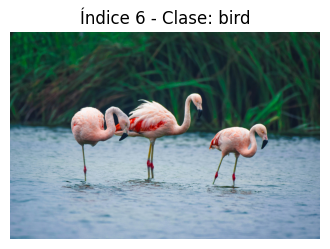

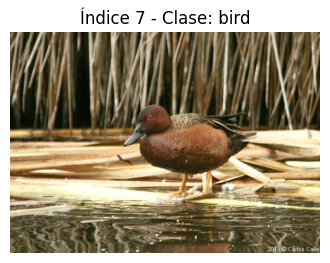

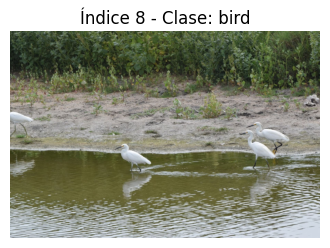

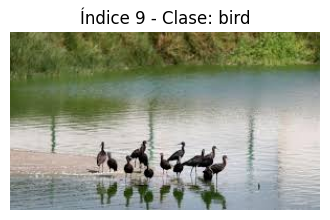

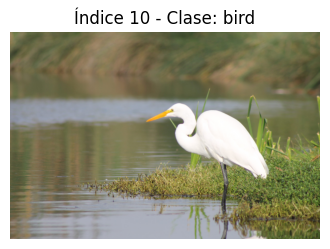

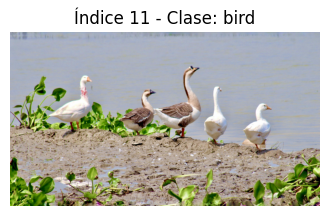

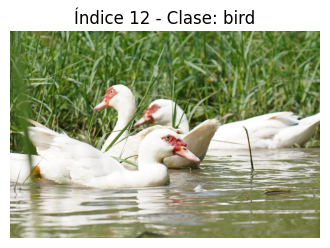

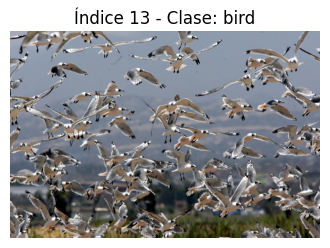

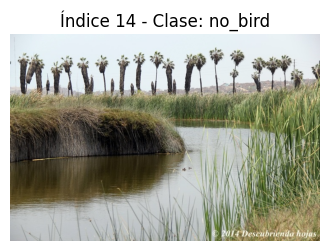

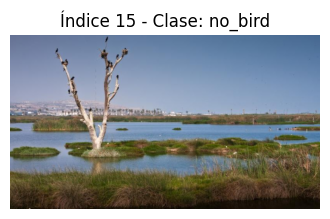

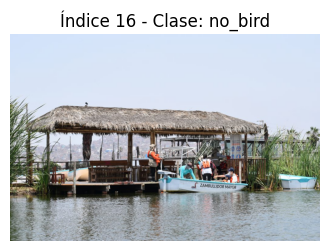

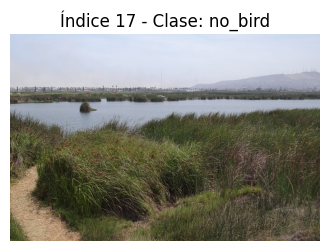

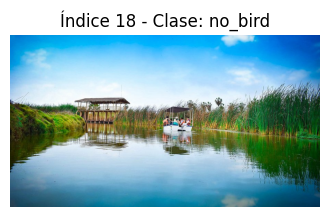

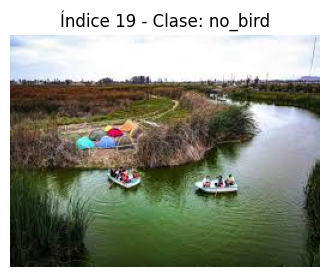

Elige el índice de la imagen que quieres guardar (0-19):  6


Imagen Images_test/bird/349664072_639634714750284_7488197136792291295_n.jpg guardada como input.npy


In [146]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Configuración de carpetas
dataset_dir = "Images_test"
classes = ["bird", "no_bird"]
deployment_dir = "deployment_dir"
os.makedirs(deployment_dir, exist_ok=True)

# Recolectar todas las imágenes disponibles
image_paths = []
image_labels = []

for cls in classes:
    cls_dir = os.path.join(dataset_dir, cls)
    if not os.path.exists(cls_dir):
        continue
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            image_paths.append(os.path.join(cls_dir, fname))
            image_labels.append(cls)

if not image_paths:
    raise RuntimeError("No se encontró ninguna imagen en el dataset.")

# Mostrar todas las imágenes con índice
for i, path in enumerate(image_paths):
    img = Image.open(path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Índice {i} - Clase: {image_labels[i]}")
    plt.axis('off')
    plt.show()

# Pedir al usuario elegir la imagen
idx = int(input(f"Elige el índice de la imagen que quieres guardar (0-{len(image_paths)-1}): "))

# Procesar la imagen elegida
img = Image.open(image_paths[idx]).convert("L")
img = img.resize((64, 64))
x = np.array(img, dtype=np.float32) / 255.0

# Cuantización a int8
x_int8 = (x * 255).astype(np.int8)
x_int8 = x_int8.flatten().reshape(1, -1)

# Guardar input.npy, formato de entrada al acelerador CNN
np.save(os.path.join(deployment_dir, "input_test.npy"), x_int8)

print(f"Imagen {image_paths[idx]} guardada como input.npy")


In [149]:
# Archivos creados
! ls {deployment_dir}


input_test.npy


In [150]:
# Exportar el .zip para implementar en la PYNQ Z2
from shutil import make_archive
make_archive('deploy-on-pynq-cnv', 'zip', deployment_dir)

'/home/parasyte/finn/notebooks/Tesis_Pynq_CNN/deploy-on-pynq-cnv.zip'